In [1]:
import  warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold, ShuffleSplit
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision
from torch import optim
from torch import cuda
from torch.optim.lr_scheduler import CosineAnnealingLR

import time, gc, random
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

import lightgbm as lgb

random.seed(2020)
np.random.seed(2020)
torch.cuda.manual_seed_all(2020)

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X

In [3]:
class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y
        
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.X)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        # argumentation
        x = self.X[index]
        x = torch.FloatTensor(x)
        
        
        if self.y!=None:
            return {
                'input': x,
                'label': torch.FloatTensor(self.y[index])
            }
        else:
            return {
                'input': x
            }

In [4]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / np.sqrt(label_to_count[self._get_label(dataset, idx)])
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        """if isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        elif self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        else:
            raise NotImplementedError"""
        return dataset.y[idx][0]
        
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [5]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        pred_1 = pred[target<1.5][:,0]
        loss_1 = torch.mean((pred_1-1)**2)
        
        pred_2 = pred[(target>1.5)&(target<2.5)][:,1]
        loss_2 = torch.mean((pred_2-1)**2)
        
        pred_3 = pred[(target>2.5)&(target<3.5)][:,2]
        loss_3 = torch.mean((pred_3-1)**2)

        pred_4 = pred[target>3.5][:,3]
        loss_4 = torch.mean((pred_4-1)**2)
        
        loss = loss_1 + loss_2 + loss_3 + loss_4
        
        return loss

In [6]:
class MLPClass(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_layers[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_layers[1], output_size)
        )
        
            
        
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.fc(x)
        #x= self.sigmoid(x)
        x= self.softmax(x)
        return x

In [7]:
class Model_Trainer:
    def __init__(self, output_size, feature, hidden_layers, lr=6e-4, weight_decay=0.0005):
        self.device =  'cuda' if cuda.is_available() else 'cpu'
        self.model = MLPClass(len(feature), output_size, hidden_layers).to(self.device)
        self.criterion = CustomLoss()
        self.optimizer = optim.Adam(params=self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = CosineAnnealingLR(optimizer=self.optimizer, T_max=10)
        self.output_size = output_size
        self.hidden_layers = hidden_layers

    
    def load_params(self, state_dict):
        self.model.load_state_dict(state_dict)

    
    def train(self, trn_dataloader):
        self.model.train()
        avg_loss=0
        all_preds = []
        all_labels = []
        for data in trn_dataloader:
            self.optimizer.zero_grad()
            x = data['input'].to(self.device)
            label = data['label'].squeeze(1)
            if len(np.unique(label))!=4:
                continue
            label = label.to(self.device)
            x = self.model(x)   
            loss = self.criterion(x, label)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            avg_loss += loss.item()/len(trn_dataloader)
            all_preds+=x.detach().cpu().tolist()
            all_labels+=label.cpu().tolist()
            
        return avg_loss, np.array(all_preds), np.array(all_labels)

    def eval(self, val_dataloader):
        self.model.eval()
        avg_loss=0
        for data in val_dataloader:
            x = data['input'].to(self.device)
            label = data['label'].to(self.device).squeeze(1)
            x = self.model(x)
            loss = self.criterion(x, label)
            avg_loss += loss.item()/len(val_dataloader)
        return avg_loss, x.detach().cpu().numpy()
    
    def predict(self, data_loader):
        self.model.eval()
        preds = []
        for data in data_loader:
            x = data['input'].to(self.device)
            preds+=self.model(x).detach().cpu().tolist()
        return np.array(preds)

In [8]:
class CustomSplit:
    def __init__(self, n_splits ,random_state):
        self.n_splits = n_splits
        self.random_state = random_state
        
    def split(self, train_df, train_label=None):
        train_df_1 = train_df[train_df.jobflag==1]
        train_df_2 = train_df[train_df.jobflag==2]
        train_df_3 = train_df[train_df.jobflag==3]
        train_df_4 = train_df[train_df.jobflag==4]
        
        kmeans=KMeans(n_clusters=5, random_state=self.random_state)
        group_1 = kmeans.fit_predict(train_df_1.drop(columns=['text_id', 'jobflag']).values) 
        group_3 = kmeans.fit_predict(train_df_3.drop(columns=['text_id', 'jobflag']).values) 
        group_4 = kmeans.fit_predict(train_df_4.drop(columns=['text_id', 'jobflag']).values) 
        
        k_1 = StratifiedShuffleSplit(n_splits=self.n_splits, random_state=self.random_state, train_size=len(train_df_2)+random.randint(-5,30))
        k_3 = StratifiedShuffleSplit(n_splits=self.n_splits, random_state=self.random_state, train_size=len(train_df_2)+random.randint(-5,30))
        k_4 = StratifiedShuffleSplit(n_splits=self.n_splits, random_state=self.random_state, train_size=len(train_df_2)+random.randint(-5,30))
        
        trn_idx_1 = []
        trn_idx_2 = train_df_2.index.tolist()
        trn_idx_3 = []
        trn_idx_4 = []    
        for trn_1, val_1 in k_1.split(train_df_1, group_1):
            trn_idx_1.append(train_df_1.iloc[trn_1].index.tolist())
        for trn_3, val_3 in k_3.split(train_df_3, group_3):
            trn_idx_3.append(train_df_3.iloc[trn_3].index.tolist())
        for trn_4, val_4 in k_4.split(train_df_4, group_4):
            trn_idx_4.append(train_df_4.iloc[trn_4].index.tolist())
        
        trn_idx = []
        for i in range(len(trn_idx_1)):
            idx = trn_idx_1[i]+trn_idx_2+trn_idx_3[i]+trn_idx_4[i]
            trn_idx.append(idx)
        return trn_idx
    
class Train_Predict:
    
    def __init__(self, train_df, test_df, feature, hidden_layers, lr=6e-4, weight_decay=0.0005, loop_num=3):
        self.train_df = train_df
        self.test_df = test_df
        self.feature = feature
        self.hidden_layers = hidden_layers
        self.lr=lr
        self.weight_decay = weight_decay
        self.loop_num=loop_num
        self.torch_random_state = 2020
        torch.cuda.manual_seed_all(self.torch_random_state)
    
    def init_model(self):
        self.model_trainer = Model_Trainer(output_size=4, feature=self.feature, hidden_layers=self.hidden_layers,
                                           lr=self.lr, weight_decay=self.weight_decay)
        
    def make_off_df(self, epoch_num, k, custom_k):
        if k==None:
            k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
            
        off_df=[]
        all_trn_loss = []
        all_val_loss = []
        kfold_num=0

        for trn, val in k.split(self.train_df, self.train_df.jobflag):
            
            all_trn_df = self.train_df.iloc[trn,:].reset_index(drop=True)
            val_df = self.train_df.iloc[val,:]
            
            val_X, val_y = val_df[self.feature].values.tolist(),val_df[['jobflag']].values.tolist() 
            val_data_set = CreateDataset(val_X, val_y)
            val_dataloader = DataLoader(val_data_set, shuffle=False, batch_size=len(val_data_set))
            
            val_preds = []
            trn_loss = []
            val_loss = []
            
            for sample_trn in tqdm(custom_k.split(all_trn_df)):
                
                trn_df = all_trn_df.iloc[sample_trn,:]
                trn_X, trn_y = trn_df[self.feature].values.tolist(),trn_df[['jobflag']].values.tolist() 
                trn_data_set = CreateDataset(trn_X, trn_y)
                trn_dataloader = DataLoader(trn_data_set, shuffle=False, batch_size=512, sampler=ImbalancedDatasetSampler(trn_data_set))
                
                sample_preds = []
                sample_trn_loss = []
                sample_val_loss = []
                
                self.init_model()
                for e in range(epoch_num):
                    trn_loss_avg, trn_preds, trn_labels = self.model_trainer.train(trn_dataloader)
                    val_loss_avg, p = self.model_trainer.eval(val_dataloader)
                    sample_preds.append(p)
                    sample_trn_loss.append(trn_loss_avg)
                    sample_val_loss.append(val_loss_avg)
                    
                val_preds.append(np.hstack(tuple(sample_preds)))
                trn_loss.append(sample_trn_loss)
                val_loss.append(sample_val_loss)
                
            val_preds_mean = np.mean(val_preds, axis=0)
            val_preds_std = np.std(val_preds, axis=0)
            
            all_trn_loss.append([np.mean(trn_loss, axis=0), np.std(trn_loss, axis=0)]  )
            all_val_loss.append( [np.mean(val_loss, axis=0),np.std(val_loss, axis=0)] )
            
            for i in range(epoch_num*4):
                label_name=(i%4)+1
                e_num=(i//4)
                val_df[f'p_mean_{e_num}_{label_name}'] = val_preds_mean[:,i]
                val_df[f'p_std_{e_num}_{label_name}'] = val_preds_std[:,i]
            val_df['num_k'] = kfold_num
            kfold_num+=1
            off_df.append(val_df)
            
        off_df = pd.concat(off_df, axis=0)
        off_df.sort_values('text_id', inplace=True)
        off_df.reset_index(drop=True, inplace=True)
        return off_df, [all_trn_loss, all_val_loss]
    
    def predict_test_df(self, epoch_num, custom_k):
        
        val_X, val_y = self.test_df[self.feature].values.tolist(), None
        val_data_set = CreateDataset(val_X, val_y)
        val_dataloader = DataLoader(val_data_set, shuffle=False, batch_size=len(val_data_set))
        
        test_preds = []
        trn_loss=[]
        test_df = self.test_df.copy()
        
        train_df = self.train_df.reset_index(drop=True)
        for trn in custom_k.split(train_df):
            trn_df = train_df.iloc[trn,:]
        
            X, y = trn_df[self.feature].values.tolist(), trn_df[['jobflag']].values.tolist()
            trn_data_set = CreateDataset(X, y)
            trn_dataloader = DataLoader(trn_data_set, shuffle=False, batch_size=512, sampler=ImbalancedDatasetSampler(trn_data_set))
            
            sample_preds = []
            sample_trn_loss=[]
            self.init_model()
            
            for e in range(epoch_num):
                trn_loss_avg, trn_preds, trn_labels = self.model_trainer.train(trn_dataloader)
                p = self.model_trainer.predict(val_dataloader)
                sample_preds.append(p)
                sample_trn_loss.append(trn_loss_avg)
                
            test_preds.append(np.hstack(tuple(sample_preds)))
            trn_loss.append(sample_trn_loss)
            
        test_preds_mean = np.mean(test_preds, axis=0)
        test_preds_std = np.std(test_preds, axis=0)
        
        for i in range(epoch_num*4):
            label_name=(i%4)+1
            e_num=(i//4)
            test_df[f'p_mean_{e_num}_{label_name}'] = test_preds_mean[:,i]
            test_df[f'p_std_{e_num}_{label_name}'] = test_preds_std[:,i]
        
        return test_df, [np.mean(trn_loss, axis=0), np.std(trn_loss, axis=0)]

In [9]:
class CustomKFlod:
    def __init__(self, n_splits, random_state, val_distribution):
        self.n_splits = n_splits
        self.random_state = random_state
        self.val_distribution = val_distribution
        
    def split(self, train_df, train_label):
        val_size = len(train_df)/self.n_splits
        val_nums = val_size*np.array(self.val_distribution)
        
        trn_idxs={}
        val_idxs={}  
        for i in range(self.n_splits):
            trn_idxs[f'idx{i}_{_}'] = []
            val_idxs[f'idx{i}_{_}'] = []
        for label in range(4):
            label_df = train_label[train_label==label+1]
            label_size = val_nums[label]/len(label_df)

            k = ShuffleSplit(n_splits=self.n_splits, train_size=label_size, random_state=self.random_state)
            for i,(trn, val) in enumerate( k.split(label_df, label_df) ):
                trn_idx = label_df.iloc[trn].index.tolist()
                val_idx = label_df.iloc[val].index.tolist()
                trn_idxs[f'idx{i}_{_}']+=trn_idx
                val_idxs[f'idx{i}_{_}']+=val_idx
                
        return zip(np.array(list((trn_idxs.values()))), np.array(list((val_idxs.values()))))

In [10]:
def make_tfidf_df(o_df):
    df = o_df.copy()
    id_cols = ['jobflag','text_id']
    preprocessing = Preprocessing()
    df['description'] = df['description'].apply(lambda x: preprocessing.change_text(x))
        
    X = preprocessing.vectorize_tfidf(df['description'])
    X = pd.concat([df[id_cols], X], axis=1)
    train_df = X[X.jobflag.notnull()].reset_index(drop=True)
    test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)
    mlp_feature = train_df.drop(columns=id_cols).columns.tolist()
    return train_df, test_df, mlp_feature

In [15]:
class All_flow:
    def __init__(self, path='../', step1_k=None, custom_k=None, step1_epoch_num=40):
        train_df = pd.read_csv(path+'train_translated.csv')
        test_df = pd.read_csv(path+'test_translated.csv')
        self.df = pd.concat([train_df, test_df],axis=0,ignore_index=True)
        self.df['text_id'] = self.df['id']
        self.df.drop(columns=['id'], inplace=True)

        self.step1_k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True) if step1_k==None else step1_k
        self.custom_k = CustomSplit(n_splits=5, random_state=2020) if custom_k==None else custom_k
            
        self.step1_epoch_num = step1_epoch_num

    def main(self):
        train_df, test_df, mlp_feature = make_tfidf_df(self.df)
        self.mlp_feature = mlp_feature
        
        train_predict = Train_Predict(train_df, test_df, self.mlp_feature, hidden_layers=[300, 100], lr=0.001, weight_decay=0.00001)

        off_df, all_cv_loss = train_predict.make_off_df(
            epoch_num=self.step1_epoch_num,k=self.step1_k, custom_k=self.custom_k
        )
        
        test_df_mlp, trn_loss_list = train_predict.predict_test_df(
            epoch_num=self.step1_epoch_num, custom_k=self.custom_k
        )
        
        add_feature = [col for col in off_df.columns if ('p_mean_' in col) or  ('p_std_' in col)]
        self.mlp_feature+=add_feature
        
        train_predict = Train_Predict(off_df, test_df_mlp, self.mlp_feature, hidden_layers=[300, 100], lr=0.001, weight_decay=0.00001)
        
        off_df, all_cv_loss = train_predict.make_off_df(
            epoch_num=self.step1_epoch_num,k=self.step1_k, custom_k=self.custom_k
        )
        
        test_df_mlp, trn_loss_list = train_predict.predict_test_df(
            epoch_num=self.step1_epoch_num, custom_k=self.custom_k
        )
        
        
        return off_df, all_cv_loss, test_df_mlp, trn_loss_list

In [16]:
custom_k=CustomSplit(n_splits=20, random_state=2020)
step1_k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
submission_model = All_flow(custom_k=custom_k, step1_k=step1_k, step1_epoch_num=45)

In [17]:
off_df, all_cv_loss, test_df_mlp, trn_loss_list = submission_model.main()

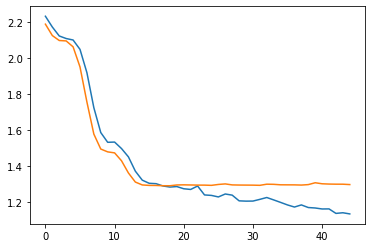

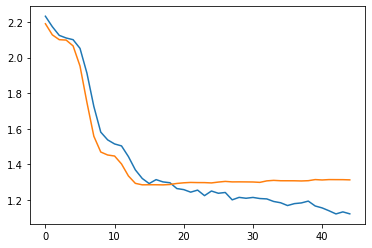

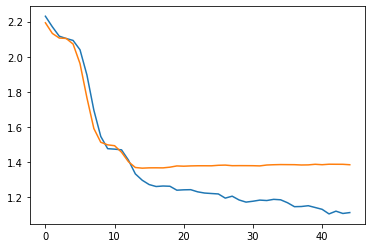

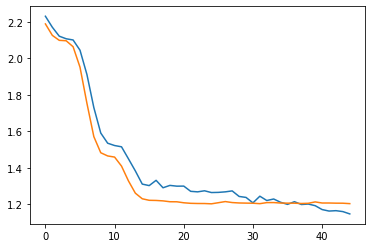

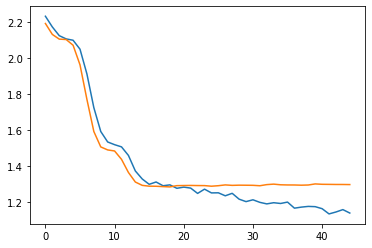

In [18]:
for i in range(len(all_cv_loss[0])):
    plt.plot(all_cv_loss[0][i][0])
    plt.plot(all_cv_loss[1][i][0])
    plt.show()

In [19]:
test_df_mlp.head()

,text_id,000,10,10g,11,12,12c,150,20,2003,...,p_mean_43_4,p_std_43_4,p_mean_44_1,p_std_44_1,p_mean_44_2,p_std_44_2,p_mean_44_3,p_std_44_3,p_mean_44_4,p_std_44_4
0,2931,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.048124,0.014771,0.082108,0.013985,0.641656,0.087083,0.232335,0.084786,0.043902,0.011242
1,2932,0.0,0.0,0.264382,0.0,0.0,0.0,0.0,0.0,0.0,...,0.173841,0.027501,0.006562,0.001677,0.023677,0.005402,0.802742,0.025021,0.167020,0.024965
2,2933,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008665,0.003164,0.067956,0.013043,0.843670,0.040674,0.080538,0.033620,0.007836,0.002416
3,2934,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003969,0.001450,0.916617,0.013097,0.077467,0.013743,0.002067,0.000806,0.003848,0.001321
4,2935,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.858496,0.034888,0.007984,0.002533,0.002877,0.001014,0.131984,0.030003,0.857155,0.030420


In [20]:
print(off_df.shape)
off_df.head()

(2931, 3747)


,jobflag,text_id,000,10,10g,11,12,12c,150,20,...,p_std_43_4,p_mean_44_1,p_std_44_1,p_mean_44_2,p_std_44_2,p_mean_44_3,p_std_44_3,p_mean_44_4,p_std_44_4,num_k
0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015713,0.005009,0.001658,0.032326,0.009520,0.924599,0.015634,0.038066,0.014832,2
1,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020333,0.003782,0.001263,0.021512,0.008585,0.904131,0.016100,0.070575,0.018061,1
2,4.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.014422,0.009858,0.003065,0.004631,0.001723,0.115637,0.014441,0.869874,0.015616,4
3,1.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.120188,0.361879,0.098438,0.035385,0.011507,0.079203,0.031051,0.523533,0.106661,3
4,4.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.045809,0.014632,0.003800,0.004584,0.001542,0.206463,0.038803,0.774321,0.037529,2


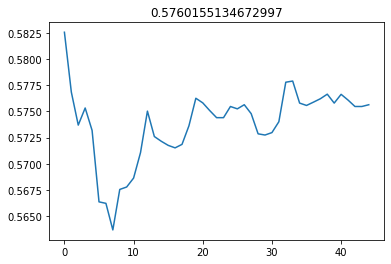

In [22]:
scores_mean=[]
scores_mean_d_std=[]
for e in range(45):
    cols = [f'p_mean_{e}_{label+1}' for label in range(4)]
    p = off_df[cols].values
    p = np.argmax(p, axis=1)+1
    scores_mean.append(
        metrics.f1_score(off_df['jobflag'], p, average='macro')
    )
plt.plot(scores_mean)
plt.title(np.mean(scores_mean[35:40]))
#plt.plot(scores_mean_d_std)
plt.show()

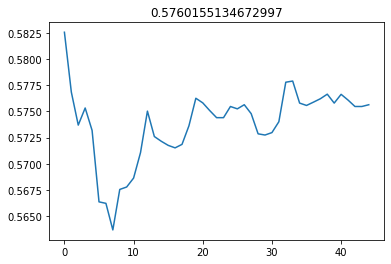

In [23]:
scores_mean=[]
scores_mean_d_std=[]
for e in range(45):
    cols = [f'p_mean_{e}_{label+1}' for label in range(4)]
    p = off_df[cols].values
    p = np.argmax(p, axis=1)+1
    scores_mean.append(
        metrics.f1_score(off_df['jobflag'], p, average='macro')
    )
plt.plot(scores_mean)
plt.title(np.mean(scores_mean[35:40]))
#plt.plot(scores_mean_d_std)
plt.show()

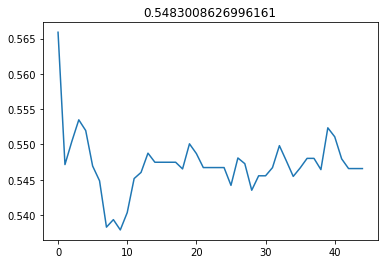

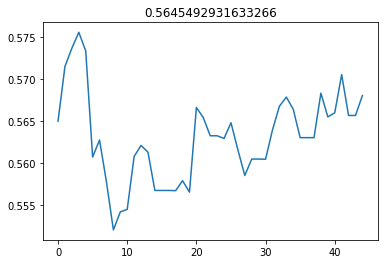

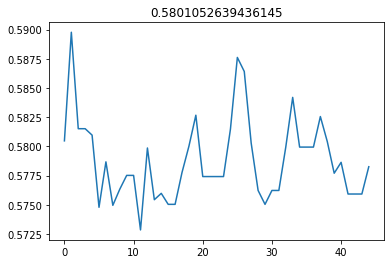

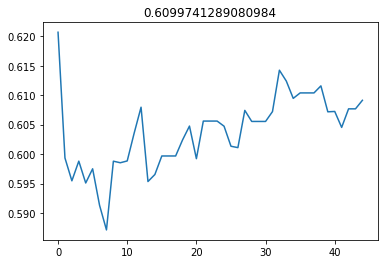

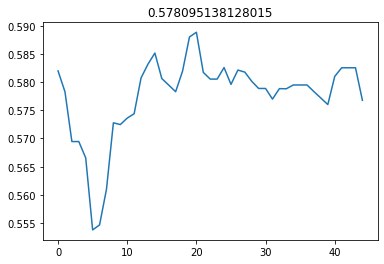

In [24]:
for k_num in off_df.num_k.unique():
    tmp_off_df = off_df[off_df.num_k==k_num]
    scores_mean=[]
    scores_mean_d_std=[]
    for e in range(45):
        cols = [f'p_mean_{e}_{label+1}' for label in range(4)]
        p = tmp_off_df[cols].values
        p = np.argmax(p, axis=1)+1
        scores_mean.append(
            metrics.f1_score(tmp_off_df['jobflag'], p, average='macro')
        )
    plt.plot(scores_mean)
    plt.title(np.mean(scores_mean[35:40]))
    #plt.plot(scores_mean_d_std)
    plt.show()

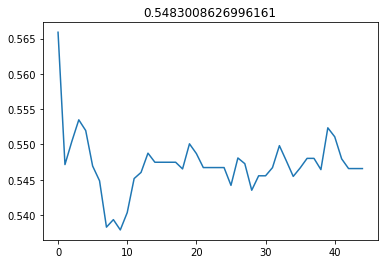

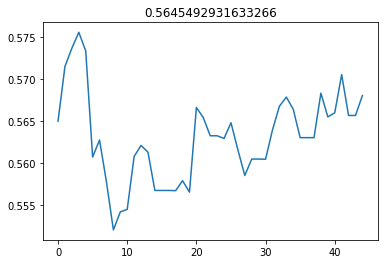

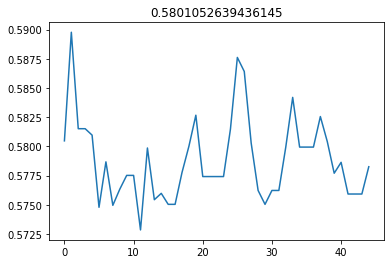

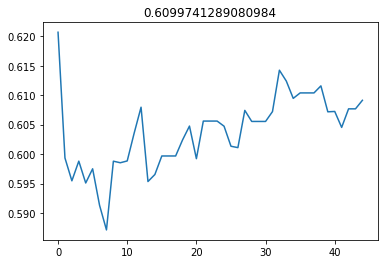

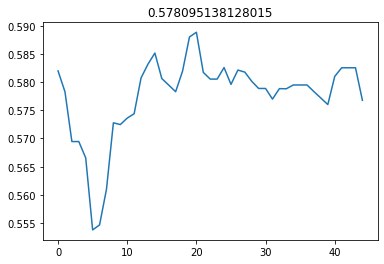

In [26]:
for k_num in off_df.num_k.unique():
    tmp_off_df = off_df[off_df.num_k==k_num]
    scores_mean=[]
    scores_mean_d_std=[]
    for e in range(45):
        cols = [f'p_mean_{e}_{label+1}' for label in range(4)]
        p = tmp_off_df[cols].values
        p = np.argmax(p, axis=1)+1
        scores_mean.append(
            metrics.f1_score(tmp_off_df['jobflag'], p, average='macro')
        )
        
    plt.plot(scores_mean)
    plt.title(np.mean(scores_mean[35:40]))
    #plt.plot(scores_mean_d_std)
    plt.show()

In [27]:
scores_mean=[]
scores_mean_d_std=[]
preds = np.zeros((len(off_df), 4))
for e in range(40,45):
    cols = [f'p_mean_{e}_{label+1}' for label in range(4)]
    preds += off_df[cols].values
p = np.argmax(preds, axis=1)+1
print(
    metrics.f1_score(off_df['jobflag'], p, average='macro')
)

0.575884887678857


In [28]:
preds = np.zeros((len(test_df_mlp), 4))
for e in range(13,20):
    cols = [f'p_mean_{e}_{label+1}' for label in range(4)]
    preds += test_df_mlp[cols].values
p = np.argmax(preds, axis=1)+1

In [29]:
test_df_mlp['final_preds'] = p

In [30]:
test_df_mlp.final_preds.value_counts(normalize=True)

3    0.307516
4    0.294320
1    0.262192
2    0.135972
Name: final_preds, dtype: float64

In [31]:
test_df_mlp[['text_id', 'final_preds']].to_csv('/Users/abcdm/Downloads/sub_23.csv', index=False, header=False)

In [36]:
data = pd.merge(
    pd.read_csv('/Users/abcdm/Downloads/sub_16.csv', header=None),
    pd.read_csv('/Users/abcdm/Downloads/sub_23.csv', header=None),
    on=[0]
)

pd.concat([
    pd.get_dummies(data['1_x']).rename(
        columns={i+1:f'{i+1}_17' for i in range(4)}
    ),
    pd.get_dummies(data['1_y']).rename(
        columns={i+1:f'{i+1}_22' for i in range(4)}
    )
], axis=1).corr().loc[
    [f'{i+1}_17' for i in range(4)],[f'{i+1}_22' for i in range(4)]
]

,1_22,2_22,3_22,4_22
1_17,0.862800,-0.171932,-0.356577,-0.342310
2_17,-0.114890,0.797453,-0.244845,-0.240963
3_17,-0.367809,-0.152247,0.801190,-0.341787
4_17,-0.326047,-0.255132,-0.338401,0.849204


In [37]:
pd.read_csv('/Users/abcdm/Downloads/sub_23.csv', header=None)

,0,1
0,2931,2
1,2932,3
2,2933,2
3,2934,1
4,2935,4
...,...,...
1738,4669,1
1739,4670,3
1740,4671,2
1741,4672,3
